# Мини туториал по Билдеру

## Представления механизма в форме графа (вершины - кинематические пары (КП), ребра - ограничения координат КП)

Такой граф будем называть __JPGraph__

In [1]:
import numpy as np
import networkx as nx
from description.kinematics import JointPoint

`JointPoint` датакласс для описания, пока что, только вращательных кинематических пар в рычажном механизме. Я предполагаю, что задания координат кинематических пар, оси вращения и соединения (ограничения на перемещение) между ними достаточно для описания пространства дизайнов рычажных механизмов. В алгоритме такое представление задается, как граф, вершины в котором кинематические пары, а ребра ограничения на изменения расстояния между вершинами. Физически ограничения будет воплощаться в виде звена робота.

Для однозначности работы алгоритма и задания ограничений на пространство поиска, добавляются флаги на кинематические пары: активируемость сочленения, присоединения к земле и к *endeffector (EE)*. В механизме обязательно должна быть одна кинематическая пара, присоединённая к земле и одна к *endeffector*. Если в механизме только одна вершина принадлежит к *endeffector*, то предполагается, что к ней в дальнейшем будет присоединен рабочий инструмент. Так как ставится условие, что к каждой кинематической паре присоединяется только 2 звена, то правильный, к примеру четырехзвенник будет выглядить так


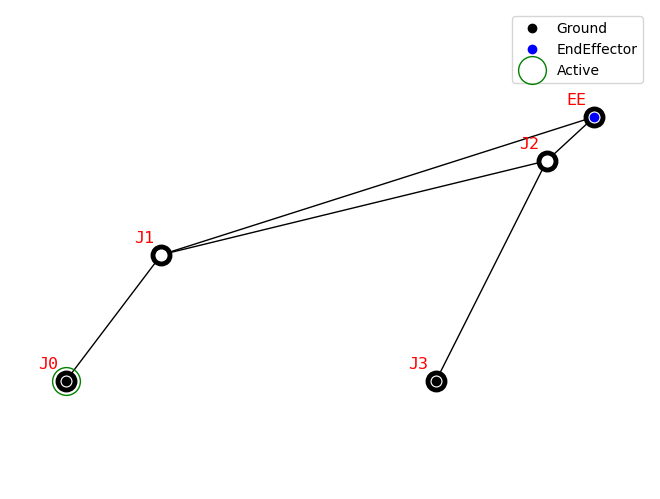

In [2]:
from auto_robot_design.description.builder import add_branch
from auto_robot_design.description.utils import draw_joint_point

graph = nx.Graph()

abs_ground = np.array([0, 0, 0])
J1 = np.array([1.087, 0, 1.435])
J2 = np.array([5.459, 0, 2.501])
J3 = np.array([4.2, 0, 0])
end = np.array([6, 0, 3])

ground_joint = JointPoint(r=abs_ground, w=np.array([0,1,0]), 
                        attach_ground=True, 
                        active=True,
                        name="J0")
joint_1 = JointPoint(r=J1, w=np.array([0,1,0]),
                     attach_endeffector=False,
                     name="J1")
joint_2 = JointPoint(J2, w=np.array([0,1,0]), 
                    attach_endeffector=False,
                    name="J2")
joint_3 = JointPoint(r=J3, w=np.array([0,1,0]),
                    attach_ground=True,
                    name="J3")
end_effector = JointPoint(r=end, w=np.array([0,1,0]),
                    attach_endeffector=True,
                    name="EE")

joints = [ground_joint, joint_1, joint_2, joint_3, end_effector]

main_branch = [ground_joint, joint_1, end_effector]
add_branch_1 = [joint_3, joint_2, [joint_1, end_effector]]

add_branch(graph, [main_branch, add_branch_1])
draw_joint_point(graph) 

Следующий механизм будет считаться не правильным так как *J2* будет присоединяться три звена:

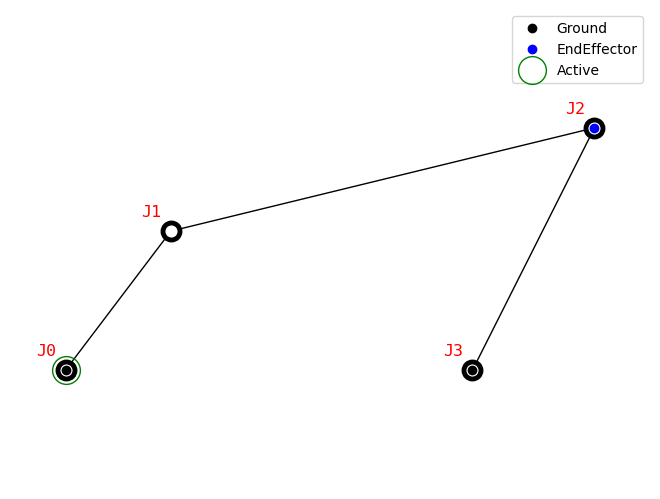

In [3]:
from auto_robot_design.description.builder import add_branch
from auto_robot_design.description.utils import draw_joint_point

graph = nx.Graph()

abs_ground = np.array([0, 0, 0])
J1 = np.array([1.087, 0, 1.435])
J2 = np.array([5.459, 0, 2.501])
J3 = np.array([4.2, 0, 0])

ground_joint = JointPoint(r=abs_ground, w=np.array([0,1,0]), 
                        attach_ground=True, 
                        active=True,
                        name="J0")
joint_1 = JointPoint(r=J1, w=np.array([0,1,0]),
                     attach_endeffector=False,
                     name="J1")
joint_2 = JointPoint(J2, w=np.array([0,1,0]), 
                    attach_endeffector=True,
                    name="J2")
joint_3 = JointPoint(r=J3, w=np.array([0,1,0]),
                    attach_ground=True,
                    name="J3")

joints = [ground_joint, joint_1, joint_2, joint_3, end_effector]

main_branch = [ground_joint, joint_1, joint_2]
add_branch_1 = [joint_3, joint_2]

add_branch(graph, [main_branch, add_branch_1])
draw_joint_point(graph) 

Еще допустимый вариант сделать одно из звеньев механизма EE-ом. В таком случае все кинематические пары должны быть присоединены к EE:

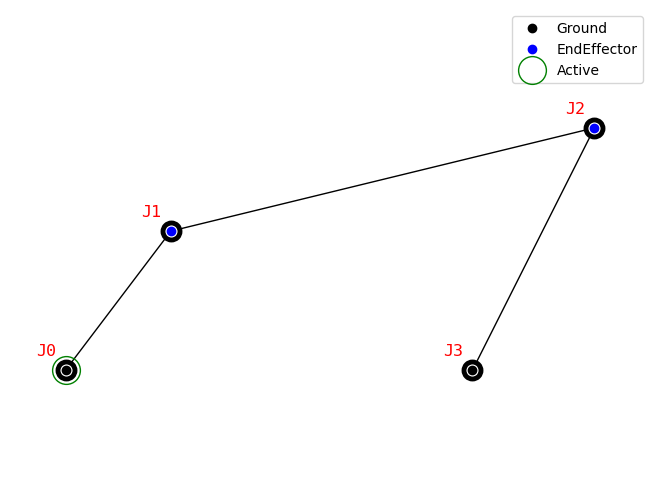

In [4]:
from auto_robot_design.description.builder import add_branch
from auto_robot_design.description.utils import draw_joint_point

graph = nx.Graph()

abs_ground = np.array([0, 0, 0])
J1 = np.array([1.087, 0, 1.435])
J2 = np.array([5.459, 0, 2.501])
J3 = np.array([4.2, 0, 0])

ground_joint = JointPoint(r=abs_ground, w=np.array([0,1,0]), 
                        attach_ground=True, 
                        active=True,
                        name="J0")
joint_1 = JointPoint(r=J1, w=np.array([0,1,0]),
                     attach_endeffector=True,
                     name="J1")
joint_2 = JointPoint(J2, w=np.array([0,1,0]), 
                    attach_endeffector=True,
                    name="J2")
joint_3 = JointPoint(r=J3, w=np.array([0,1,0]),
                    attach_ground=True,
                    name="J3")

joints = [ground_joint, joint_1, joint_2, joint_3, end_effector]

main_branch = [ground_joint, joint_1, joint_2]
add_branch_1 = [joint_3, joint_2]

add_branch(graph, [main_branch, add_branch_1])
draw_joint_point(graph) 

Обязательно, каждая кинематическая пара должна быть связано с другими. Другими словами в графе между двумя любыми вершинами есть хотя бы один путь. В графе не должно быть петлей (начало и конец ребра в одной вершине) и несколько ребер между двумя вершинами. Строго говоря мы рассматриваем простые связные графы.

Для упрощения будем рассматривать только планарные механизмы в плоскости $XZ$, поэтому ось вращения для всех кинематических пар будет равна $w = \begin{bmatrix} 0 & 1 & 0 \end{bmatrix}$. То есть вращения всех пар происходит по оси $Y$. Теперь опишем код для построения механизмов.

In [5]:
graph = nx.Graph() # Класс графа из библиотеки networkx. 
# В нем вершины будут кинематические пары, а ребра - ограничения на перемещения пар в плоскости относительно друг друга. 

# Задается координаты кинематических пар
abs_ground = np.array([0, 0, 0])
J1 = np.array([1.087, 0, 1.435])
J2 = np.array([5.459, 0, 2.501])
J3 = np.array([4.2, 0, 0])
end = np.array([6, 0, 3])


 Создаем структуры для описания кинематических пар, в которых будет содержаться информация:
- `r` - координата кинематической пары в глобальной с. к. 
- `w` - ось вращения пары
- `attach_ground` - флаг присоединения к земле
- `attach_endeffector` - флаг присоединения к EE
- `active` - флаг, что пара активируемая
- `name` - название (не обязательно указывать)

In [6]:
ground_joint = JointPoint(r=abs_ground, w=np.array([0,1,0]), 
                        attach_ground=True, 
                        active=True,
                        name="J0")
joint_1 = JointPoint(r=J1, w=np.array([0,1,0]),
                     attach_endeffector=False,
                     name="J1")
joint_2 = JointPoint(J2, w=np.array([0,1,0]), 
                    attach_endeffector=False,
                    name="J2")
joint_3 = JointPoint(r=J3, w=np.array([0,1,0]),
                    attach_ground=True,
                    name="J3")
end_effector = JointPoint(r=end, w=np.array([0,1,0]),
                    attach_endeffector=True,
                    name="EE")
joints = [ground_joint, joint_1, joint_2, joint_3, end_effector]

Чтобы связать несколько вершин, можно вручную прописать ребра в `graph` методом `add_edge`. Так можно совершить ошибки и сделать неправильный граф. Поэтому можно прописать кинематические цепочки и добавить их в граф функцией `add_branch`. Такой способ удобен, а также можно рассматривать как добавления групп Ассура к механизму открытой кинематики. Пример дальше представлен.

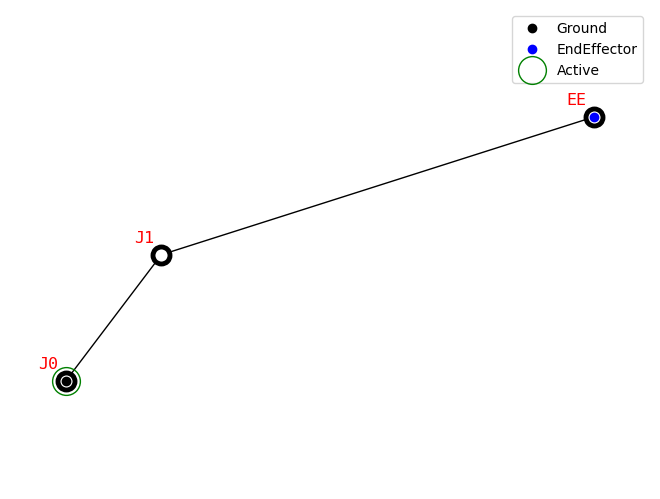

In [7]:
from auto_robot_design.description.builder import add_branch
from auto_robot_design.description.utils import draw_joint_point
main_branch = [ground_joint, joint_1, end_effector] # Основная кинематическая цепочка - Механизм открытой кинематики
# Он создаст по сути звенья (ground_joint,joint_1) -> (joint_1, end_effector)

add_branch(graph, main_branch)
draw_joint_point(graph) 

Добавления группы Ассура (1n2p) редуцирующий степень свободы на один. Изначальный метод работает с присоединения к звеньям, поэтому в конце указывается две вершины, чтобы наложить ограничения на перемещения относительно двух кинематических пар. 

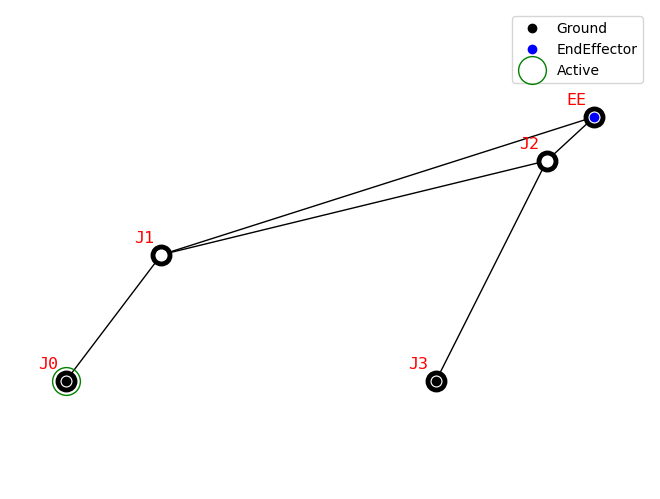

In [8]:
add_branch_1 = [joint_3, joint_2, [joint_1, end_effector]] 

add_branch(graph, add_branch_1)
draw_joint_point(graph) 

## Кинематический граф

Использовать такое представление удобно для генерации и синтеза рычажных механизмов. Для анализа удобней пользоваться графом связности системы, который описан в книге *Roy Featherstone, Rigid Body Dyanmics Algorithms*. Вершины в графе связности абсолютно твердые тела, ребра - кинематические пары. Одна вершина - зафиксированное тело (земля, база). Граф является неориентированный и обязательно связным. Функция `JointPoint2KinematicGraph` преобразует в новое представление. Для удобста будем его называть кинематический граф, по аналогии с кинематическим деревом. 

Далее показано разделение графа на тела. Я вывел простые правила, по которым любой JPGraph можно преобразовать в кинематический граф.

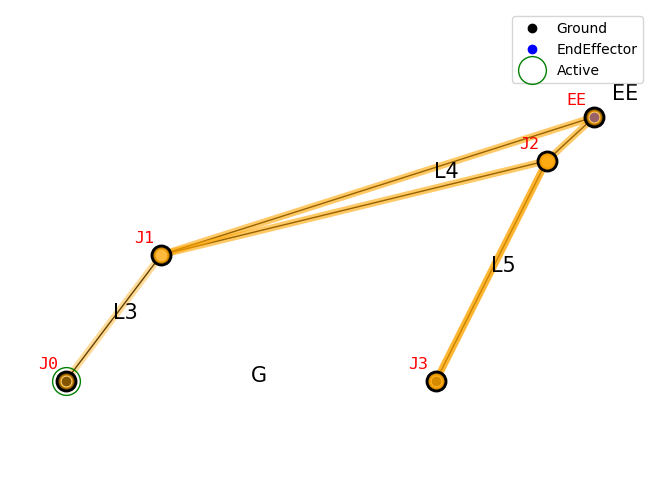

In [9]:
from auto_robot_design.description.mechanism import JointPoint2KinematicGraph
from auto_robot_design.description.utils import draw_links

kinematic_graph = JointPoint2KinematicGraph(graph)
draw_links(kinematic_graph, graph)


`kinematic_graph` - в вершинах содержат датакласс `Link`, который содержит всю информацию о теле. Пока что он не дописан полностью. В ребрах содержится `JointPoint`

Вот результат работы функции. Черными ребрами показывают на активируемость джоинта между телами. 

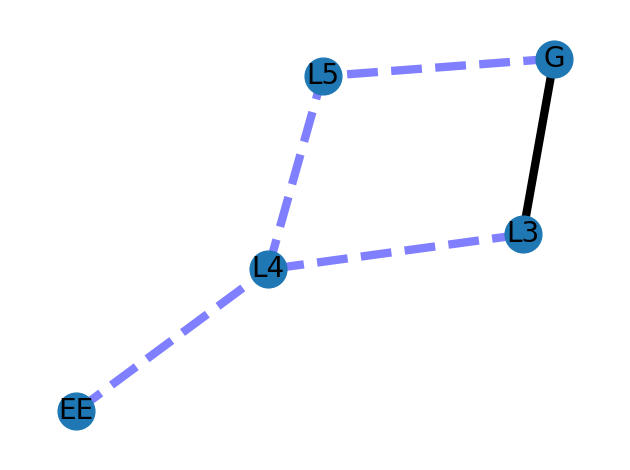

In [10]:
from auto_robot_design.description.utils import draw_kinematic_graph
draw_kinematic_graph(kinematic_graph)

По полученному графу необходимо получить остовное дерево (span tree) для дальнейших алгоритмов. _Википедия:_ Неформально говоря, остовное дерево получается из исходного графа удалением максимального числа рёбер, входящих в циклы, но без нарушения связности графа. В общем, граф содержит несколько span tree. 

Необходимо задать правила для получения удобного span tree для последующих алгоритмов.

 - Удаленные ребра в среде моделирования будут задаваться, как ограничения в системе (`equation`, `constraint`). 
- Нельзя разрывать ребра, в которых активные кинематические пары. В системе нельзя поставить актуатор на ограничения. 
- Желательно разрывать кинематические циклы при присоединении к основной кин. цепочке. 
- Один из листьев дерева должен быть *EE*. 

По данным правила рассчитываются веса ребер. А дальше алгоритм из библиотеки `networkx` ищет span tree с максимальной суммой весов. 

Если граф был получен не с помощью _respawn algorithm_, то нам неизвестна механизм открытой кинематики (основная кин. цепь.). Основной веткой будет считаться ветка с наибольшей длиной и с наибольшим количеством актуаторов. По данным правилам рассчитываются уже новые веса. 

Функция `get_span_tree_n_main_branch` возвращает span tree, который будет называться кинематическим деревом, и основную ветку механизма. 

In [11]:
from auto_robot_design.description.mechanism import get_span_tree_n_main_branch

kinematic_tree, main_branch = get_span_tree_n_main_branch(kinematic_graph)

EE L4 0.0
G L3 520.18
G L5 20.28
L3 L4 10.516
L4 L5 10.45


In [12]:
main_branch

['G', 'L3', 'L4', 'EE']

Для кинематического дерева рассчитываются системы координат относительно предыдущего звена. Это необходимо для построения _URDF/MJCF_ представления

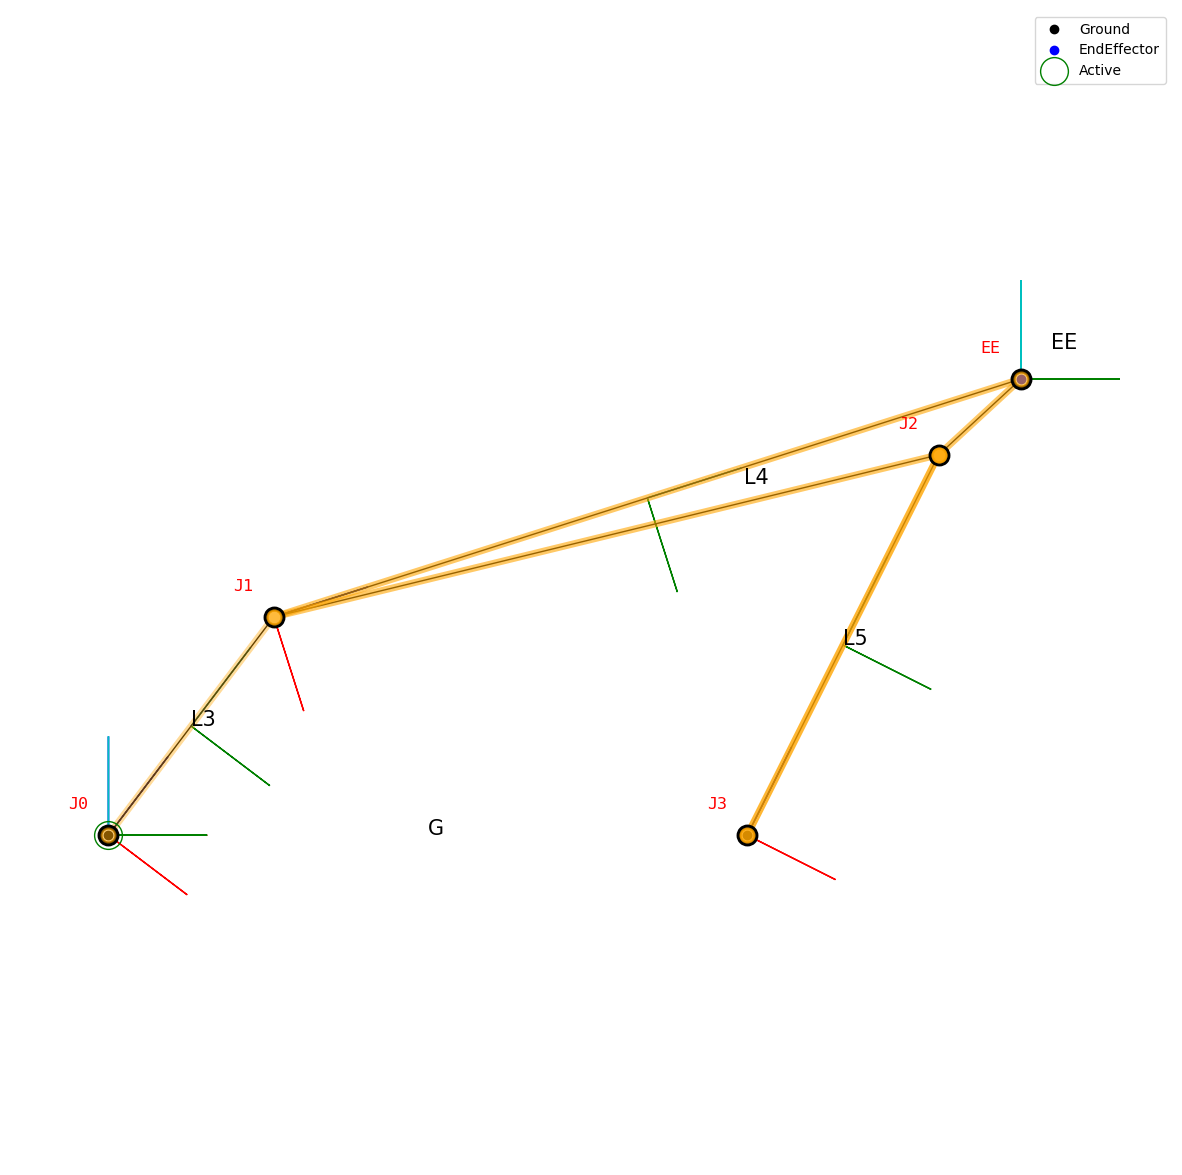

In [13]:
from auto_robot_design.description.mechanism import define_link_frames
from auto_robot_design.description.utils import draw_link_frames

define_link_frames(kinematic_graph, kinematic_tree, main_branch=main_branch, all_joints=graph.nodes())


draw_link_frames(kinematic_graph)
draw_links(kinematic_graph, graph)

`create_urdf` - функция создает urdf представления по кинематическому графу.

In [18]:
from auto_robot_design.description.builder import create_urdf

urdf_robot = create_urdf(kinematic_graph)
# print(urdf_robot)

KeyError: 'frame_geom'

In [2]:
arr = [0, 1]

arr[-1], arr[-2]

(1, 0)

In [11]:
import networkx as nx 

graph = nx.path_graph(5)

[2,3] in graph.edges()

True